For some reason this requires that the input dimensions aren't already defined in the code, and that the batch number isn't, otherwise it will overwrite the outcome. For this reason we have to use my_lenet_view.prototxt instead of my_lenet.

In [1]:
caffe_root = '/home/alex/Caffe/caffe/'
import sys
sys.path.insert(0, caffe_root + 'python')
import caffe
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# This just customizes a few aspects of the plots
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

import os
if not os.path.isfile('snapshot_iter_500.caffemodel'):
    print "oops"

Load up the network (or at least a snapshot of one)

In [2]:
caffe.set_mode_cpu()
net = caffe.Net('my_lenet_view.prototxt',
                'snapshot_iter_500.caffemodel',
                caffe.TEST)

LMDB is the module to process information in the lmdb format

In [3]:
import lmdb

The data is loaded using the lmdb module, and the caffe data reader.

In [4]:
import struct
from caffe.proto import caffe_pb2
lmdb_env = lmdb.open("mnist_train_lmdb")
csr = lmdb_env.begin().cursor()
csr.first()
imageNo, image = csr.item()
datum = caffe_pb2.Datum()

In [5]:
datum.ParseFromString(image)
data = caffe.io.datum_to_array(datum)
print datum.label
print data[0][0][range(0,10)]
net.blobs['data'].reshape(1,1,28,28)
net.blobs['data'].data[...] = data

5
[0 0 0 0 0 0 0 0 0 0]


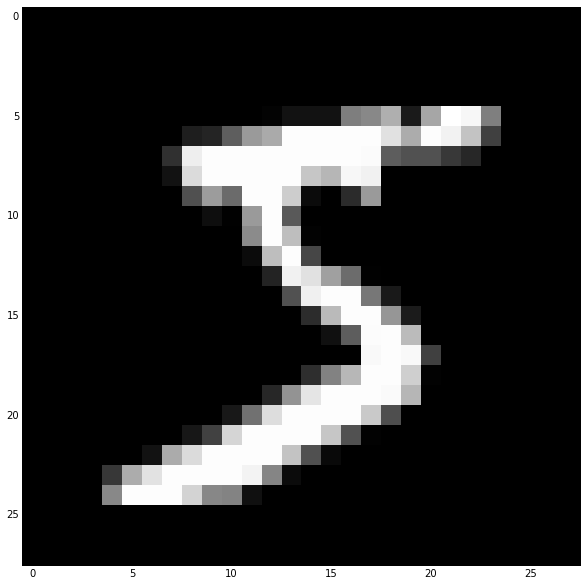

In [72]:
plt.imshow(data[0])

Again we're using a helper function from earlier - this is from the visualising net properties tutorial. This one has been slightly modified to account for the fact that we're using greyscale images

In [78]:
def vis_square(data, padsize=0, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    data = data.squeeze()
    plt.imshow(data, cmap='Greys_r')

This code runs the network forwards, and then looks to see which class was predicted (basically is the net any good). 

In [18]:
out = net.forward()
print("The dimensions of the output are {}.".format(out['prob'].shape))
print("The actual probabilities were {}.".format(out['prob']))
print("The chosen class is {}.".format(out['prob'].argmax()))

The dimensions of the output are (1, 10).
The actual probabilities were [[  4.75909978e-09   5.48999378e-06   3.96192490e-07   1.87581405e-02
    1.75086939e-06   9.80804861e-01   1.56302176e-05   5.67847547e-09
    4.12842666e-04   8.20012872e-07]].
The chosen class is 5.


Looking at the shape of the net as dictated by the loaded network

In [19]:
[(k, v.data.shape) for k, v in net.blobs.items()]

[('data', (1, 1, 28, 28)),
 ('conv1', (1, 20, 24, 24)),
 ('pool1', (1, 20, 12, 12)),
 ('conv2', (1, 16, 8, 8)),
 ('pool2', (1, 16, 4, 4)),
 ('ip1', (1, 84)),
 ('ip2', (1, 10)),
 ('prob', (1, 10))]

Now let's look at some of the filters that have been identified

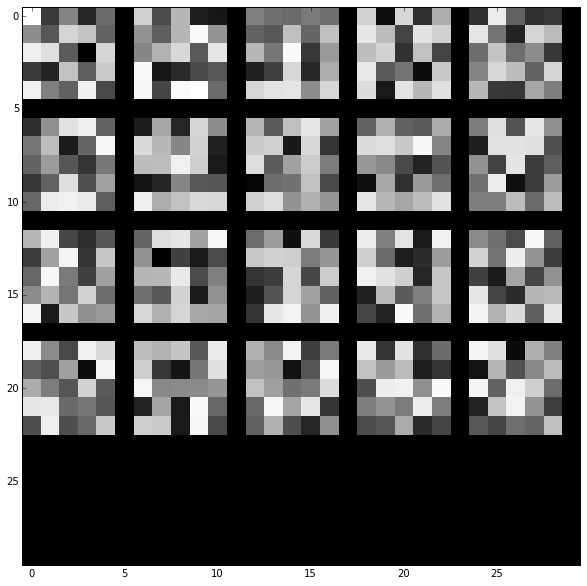

In [82]:
filters = net.params['conv1'][0].data
vis_square(filters.transpose(0, 2, 3, 1), padsize=1)

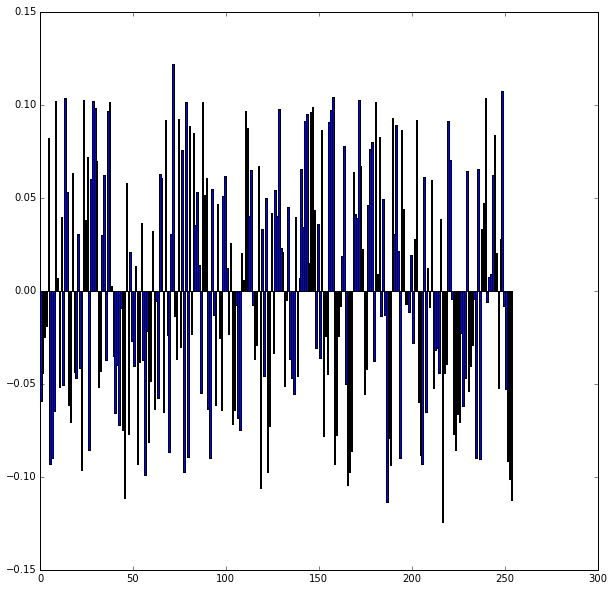

In [90]:
feat = net.params['ip1'][0].data[0]
plt.bar(range(0,len(feat.flat)),feat.flat);